## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
import scipy
import tensorflow as tf

import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
50682,00012834_087.png,Consolidation|Pneumothorax,87,12834,33,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012834_087.png
104721,00028050_002.png,No Finding,2,28050,44,M,PA,3056,2544,0.139,0.139,NaN,/data/images_011/images/00028050_002.png
89919,00022333_000.png,Infiltration,0,22333,24,F,PA,2434,2693,0.143,0.143,NaN,/data/images_010/images/00022333_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

# Split Finding Labels into 1-hot encoding

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
41486,00010723_008.png,Pleural_Thickening,8,10723,52,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
51933,00013111_066.png,Emphysema|Pneumothorax,66,13111,23,M,PA,2992,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19112,00005069_024.png,No Finding,24,5069,26,F,PA,2662,2625,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

all_xray_df['pneumonia_class'] = np.where(all_xray_df['Pneumonia']==1, 'True', 'False')
    

In [5]:
all_xray_df['pneumonia_class'].value_counts()

False    110689
True       1431
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, val_data = skl.train_test_split(df,
                                          test_size=0.2,
                                          stratify=df['Pneumonia'])
    
    return train_data, val_data

In [7]:
train_df, valid_df = create_splits(all_xray_df) 

In [8]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
55360,00013876_007.png,Cardiomegaly,7,13876,50,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
87618,00021648_007.png,No Finding,7,21648,21,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
94959,00024679_000.png,Infiltration,0,24679,45,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False
44355,00011413_001.png,No Finding,1,11413,54,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
46788,00011943_000.png,No Finding,0,11943,33,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False


In [9]:
train_df['Pneumonia'].sum()/len(train_df)

0.012765340706386016

In [10]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.012754191937210132

The dataset has been split correctly since we have both a 1.27% representation of Pneumonia cases in each data frame.

In [11]:
plt.style.use('bmh')

In [12]:
#Train_df
#Measure frequency

train_freq = []
for i in all_labels:
    rate = train_df[i].sum()/len(train_df)
    train_freq.append(rate)
    
valid_freq = []
for i in all_labels:
    rate = valid_df[i].sum()/len(valid_df)
    valid_freq.append(rate)
#valid_freq = valid_df[all_labels].sum()/len(train_df)

freq_df = pd.DataFrame({'Disease': all_labels ,'train_fq':train_freq, 'valid_fq':valid_freq})
freq_df

,Disease,train_fq,valid_fq
0,Atelectasis,0.102792,0.104308
1,Cardiomegaly,0.024773,0.024706
2,Consolidation,0.041206,0.043302
3,Edema,0.020079,0.022387
4,Effusion,0.119203,0.117062
5,Emphysema,0.022431,0.022476
6,Fibrosis,0.015151,0.014583
7,Hernia,0.001962,0.002274
8,Infiltration,0.177355,0.177756
9,Mass,0.051552,0.051641


[Text(0.5, 0, 'Disease')]

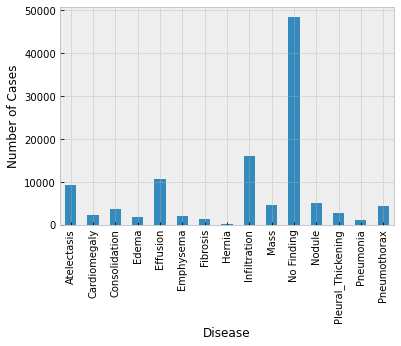

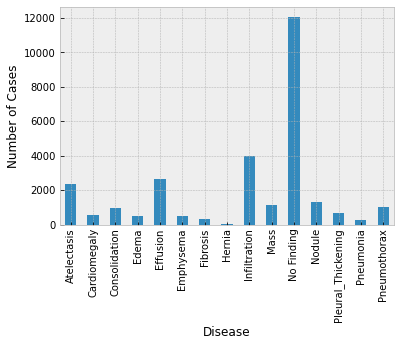

In [13]:
#plot train
plt.subplots(1, 1)
ax = (train_df[all_labels].sum()).plot(kind='bar')
ax.set(ylabel='Number of Cases')
ax.set(xlabel='Disease')

# Valid_df
plt.subplots(1, 1)
ax = (valid_df[all_labels].sum()).plot(kind='bar')
ax.set(ylabel='Number of Cases')
ax.set(xlabel='Disease')
#plot distribution picking up top 30%
#plt.figure(figsize=(16,6))
#train_df[train_df.Pneumonia==1]["Finding Labels"].value_counts()[0:30].plot(kind='bar')

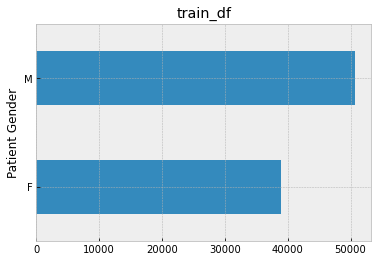

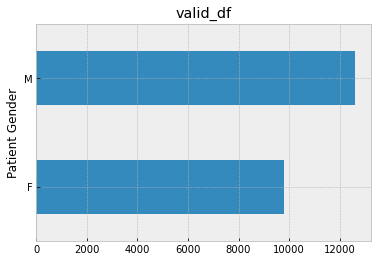

In [14]:
# Check Gender Balance
plt.subplots(1, 1)
x = (train_df.groupby('Patient Gender').size().plot(kind='barh'))
plt.title("train_df")

plt.subplots(1, 1)
x = (valid_df.groupby('Patient Gender').size().plot(kind='barh'))
plt.title("valid_df")
plt.show()

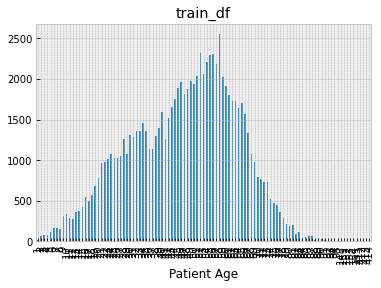

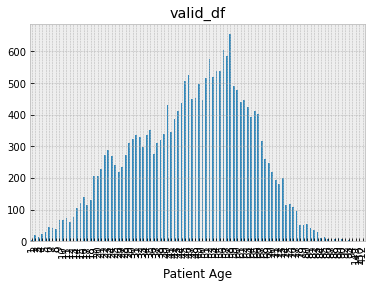

In [15]:
# Age

# Check Gender Balance
plt.subplots(1, 1)
x = (train_df.groupby('Patient Age').size().plot(kind='bar'))
plt.title("train_df")

plt.subplots(1, 1)
x = (valid_df.groupby('Patient Age').size().plot(kind='bar'))
plt.title("valid_df")
plt.show()

### Student Response: Initial representation is correct! :)

- In terms of Pneumonia, Other Disease, Gender, and Age both training and validation sets have equal representation!

### Condition 1 - To have EQUAL amount of positive and negative cases of Pneumonia in Training

But.... we know that we want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia, so we're going to have to throw away some data:

In [16]:
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds, len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
len(train_df)

2290

In [17]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

We validated that our training dataset has equal (50/50) composition of positive vs non-positive pneumonia cases

### Condition 2 - To have 12% positive cases of Pneumonia in the Test Set

Now, we have to comply with the second condition that is that our validation set should be representative of real world cases. In our case, due to unavailability of data we assume that the prevalence of pneumonia in our dataset is representative of the real world so we are going to stick to the 12% 

In [18]:
p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds, len(p_inds)*4)
valid_df = valid_df.loc[p_inds + np_sample]

In [19]:
valid_df['Pneumonia'].sum()/len(valid_df)

0.2

Yaii! Now we have a valid_df that is representative of the real world, but now I want to double-check again if our representativeness of other variables changed

In [20]:
#Train_df
#Measure frequency

train_freq = []
for i in all_labels:
    rate = train_df[i].sum()/len(train_df)
    train_freq.append(rate)
    
valid_freq = []
for i in all_labels:
    rate = valid_df[i].sum()/len(valid_df)
    valid_freq.append(rate)
#valid_freq = valid_df[all_labels].sum()/len(train_df)

freq_df = pd.DataFrame({'Disease': all_labels ,'train_fq':train_freq, 'valid_fq':valid_freq})
freq_df

,Disease,train_fq,valid_fq
0,Atelectasis,0.142358,0.113986
1,Cardiomegaly,0.027511,0.020979
2,Consolidation,0.069432,0.050350
3,Edema,0.120087,0.072727
4,Effusion,0.141048,0.127273
5,Emphysema,0.018341,0.030070
6,Fibrosis,0.008297,0.014685
7,Hernia,0.002183,0.002098
8,Infiltration,0.300437,0.216084
9,Mass,0.050218,0.046853


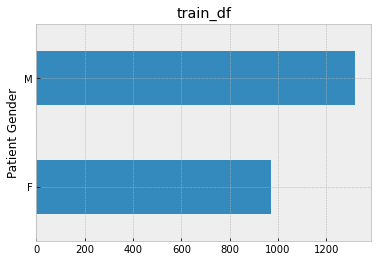

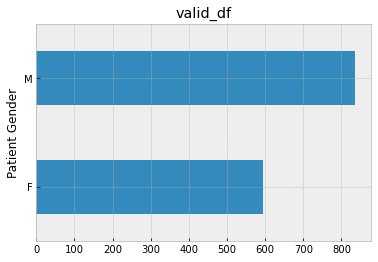

In [21]:
# Check Gender Balance
plt.subplots(1, 1)
x = (train_df.groupby('Patient Gender').size().plot(kind='barh'))
plt.title("train_df")

plt.subplots(1, 1)
x = (valid_df.groupby('Patient Gender').size().plot(kind='barh'))
plt.title("valid_df")
plt.show()

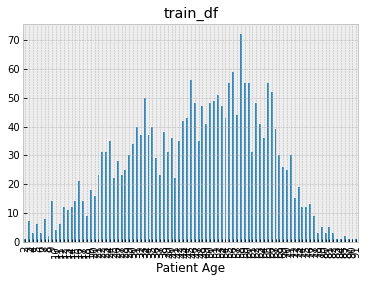

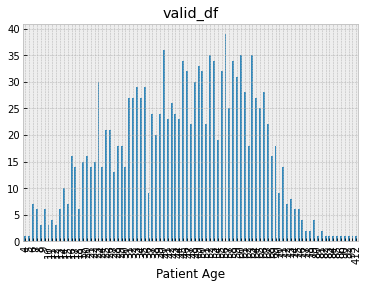

In [22]:
# Age

# Check Gender Balance
plt.subplots(1, 1)
x = (train_df.groupby('Patient Age').size().plot(kind='bar'))
plt.title("train_df")

plt.subplots(1, 1)
x = (valid_df.groupby('Patient Age').size().plot(kind='bar'))
plt.title("valid_df")
plt.show()

### Student Response:

- Disease presence: yeah it changed a bit but its understandable given that we intentionally created an imbalance relative to pneumonia and in healthcare many diseases have correlations and comorbidity. For instance, from our EDA we infered that the most related diseases to pneumonia are infiltration, edema, atelectasis... these diseases have suffered an imbalance while other diseases such as Consolidation or Mass were bearly affected.
- Gender: Yes, it changed a bit as well. Female representation is higher in validation set. Not an extreme difference but something to consider
- Age, yeah it was affected as well. But conserves the form.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [23]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    
    
    return my_idg


def make_train_gen(train_df):
    
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                      directory=None, 
                                      x_col = "path",
                                      y_col ="pneumonia_class",
                                      class_mode ='binary',
                                      target_size = (224,224), #224*224 for input size required by VGG16
                                      batch_size = 32
                                      )
     # Todo

    return train_gen


def make_val_gen(valid_df):
    
    
    my_val_idg = ImageDataGenerator(rescale=1. / 255.0)
                                    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = valid_df, 
                                          directory=None, 
                                          x_col = "path",
                                          y_col ="pneumonia_class",
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 32) 
    
    # Todo
    return val_gen

In [24]:
train_gen = make_train_gen(train_df)

Found 2290 validated image filenames belonging to 2 classes.


In [25]:
len(train_gen)

72

In [26]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(valid_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [27]:
len(val_gen)

45

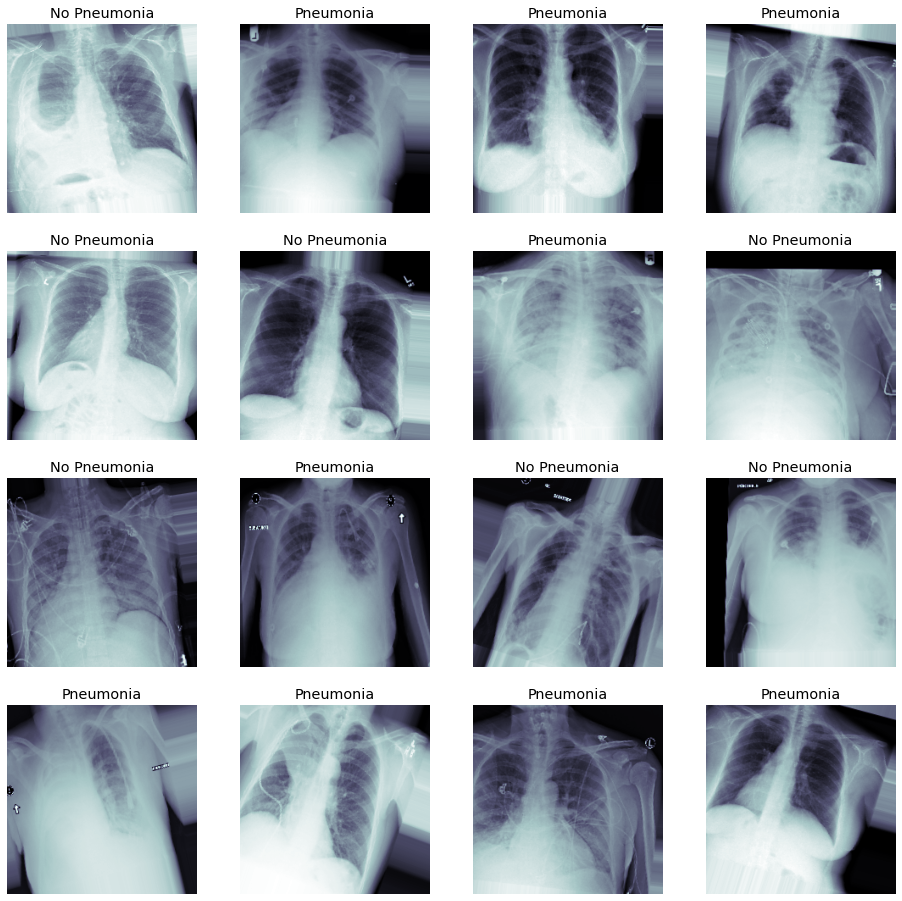

In [28]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [29]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [30]:
lay_of_interest = 'block5_pool'
vgg_model = load_pretrained_model(lay_of_interest)

553467904/553467096 [==============================] - 6s 0us/step


In [31]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [32]:
for layer in vgg_model.layers[0:18]:
    layer.trainable = False

In [33]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool True


In [34]:
def build_my_model(model_1):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()
    
    my_model.add(model_1)
    
    #v1
    
    #my_model.add(Dense(1, activation='sigmoid'))
    
    #v2
    my_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))

    
    return my_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [35]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=20)

callbacks_list = [checkpoint, early]

### Start training! 

In [36]:
model_1 = vgg_model
my_model = build_my_model(model_1)
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [37]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

# Compile it
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [38]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 30, 
                           callbacks = callbacks_list)

Epoch 1/30
72/72 [==============================] - 65s 909ms/step - loss: 0.8060 - binary_accuracy: 0.5035 - val_loss: 0.6777 - val_binary_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 0.67770, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 60s 840ms/step - loss: 0.7573 - binary_accuracy: 0.5157 - val_loss: 0.6675 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss improved from 0.67770 to 0.66749, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
72/72 [==============================] - 61s 844ms/step - loss: 0.7354 - binary_accuracy: 0.5170 - val_loss: 0.6138 - val_binary_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.66749 to 0.61384, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
72/72 [==============================] - 61s 846ms/step - loss: 0.7288 - binary_accuracy: 0.5349 - val_loss: 0.9751 - val_binary_accuracy: 0.1562

Epoch 00004: val_loss did not improve from 0.61384
Epoch 5/30
72/7

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [39]:
def load_prev_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        saved_model = json_file.read()

    model = tf.keras.models.model_from_json(saved_model)
    model.summary()

    model.load_weights(weight_path)
    
    return model

In [40]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# Model on Training
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 16, verbose = True)

#Load old model
'''
model_path = 'my_model_1.json' #path to saved model
weight_path = 'xray_class_my_model.best.hdf5' #path to saved best weights
my_old_model = load_prev_model(model_path, weight_path)

pred_Y = my_old_model.predict(valX, batch_size = 32, verbose = True)
'''

32/32 [==============================] - 2s 68ms/step


"\nmodel_path = 'my_model_1.json' #path to saved model\nweight_path = 'xray_class_my_model.best.hdf5' #path to saved best weights\nmy_old_model = load_prev_model(model_path, weight_path)\n\npred_Y = my_old_model.predict(valX, batch_size = 32, verbose = True)\n"

In [41]:
from sklearn.metrics import brier_score_loss, accuracy_score, auc, f1_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [42]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    

    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1_threshold_curve(precision, recall, thresholds):
    
    f1 = calc_f1(precision, recall)[:-1]
    print(f1)
    tr = thresholds
    
    #Plot
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(tr, f1)
    c_ax.legend()
    c_ax.set_xlabel('Thresholds')
    c_ax.set_ylabel('F1-Score')
    

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    '''
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    '''
    
    # Todo
    #Plot Accuracy
    #plt.style.use("ggplot")
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('# of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # Plot Loss
    plt.style.use("ggplot")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    return

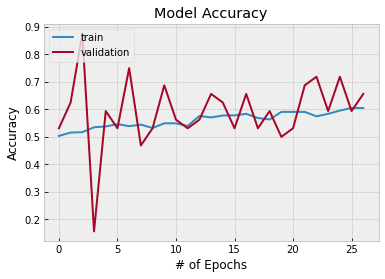

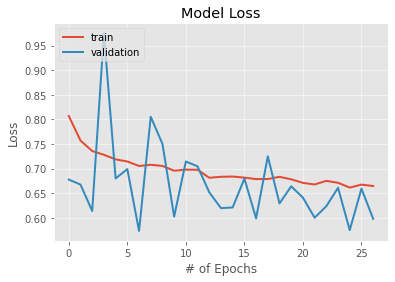

In [43]:
## plot figures

plot_history(history)
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [44]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [45]:
valY

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

In [46]:
pred_Y

array([[0.29841924],
       [0.5098434 ],
       [0.33203125],
       [0.49544048],
       [0.47233024],
       [0.4606832 ],
       [0.39041114],
       [0.48477072],
       [0.35464326],
       [0.36016092],
       [0.48807406],
       [0.34648144],
       [0.33861658],
       [0.44727793],
       [0.34022015],
       [0.5364439 ],
       [0.5535347 ],
       [0.4645006 ],
       [0.34869006],
       [0.43594006],
       [0.48600525],
       [0.4072838 ],
       [0.3690972 ],
       [0.40654936],
       [0.37411603],
       [0.3366276 ],
       [0.5254484 ],
       [0.45080274],
       [0.5063298 ],
       [0.29086962],
       [0.36152714],
       [0.435191  ]], dtype=float32)

### AUC

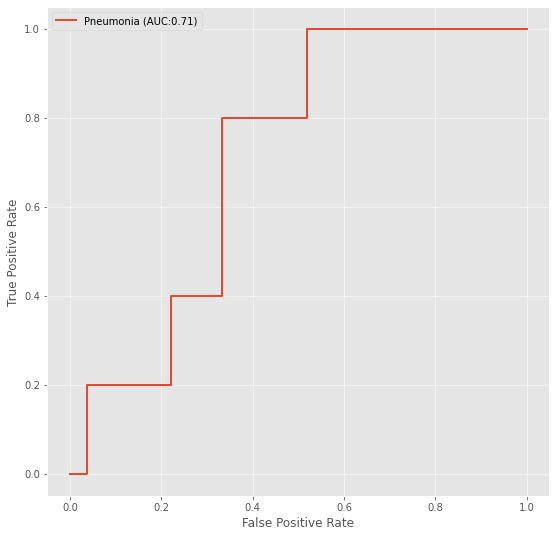

In [47]:
plot_auc(valY, pred_Y)

### Precision-Recall and Thresholds

In [48]:
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)

In [49]:
thresholds

array([0.39041114, 0.40654936, 0.4072838 , 0.435191  , 0.43594006,
       0.44727793, 0.45080274, 0.4606832 , 0.4645006 , 0.47233024,
       0.48477072, 0.48600525, 0.48807406, 0.49544048, 0.5063298 ,
       0.5098434 , 0.5254484 , 0.5364439 , 0.5535347 ], dtype=float32)

In [50]:
precision

array([0.26315789, 0.22222222, 0.23529412, 0.25      , 0.26666667,
       0.28571429, 0.30769231, 0.25      , 0.18181818, 0.2       ,
       0.22222222, 0.25      , 0.14285714, 0.16666667, 0.2       ,
       0.25      , 0.33333333, 0.5       , 0.        , 1.        ])

In [51]:
recall

array([1. , 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.6, 0.4, 0.4, 0.4, 0.4, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. ])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


[0.41666667 0.34782609 0.36363636 0.38095238 0.4        0.42105263
 0.44444444 0.35294118 0.25       0.26666667 0.28571429 0.30769231
 0.16666667 0.18181818 0.2        0.22222222 0.25       0.28571429
        nan]


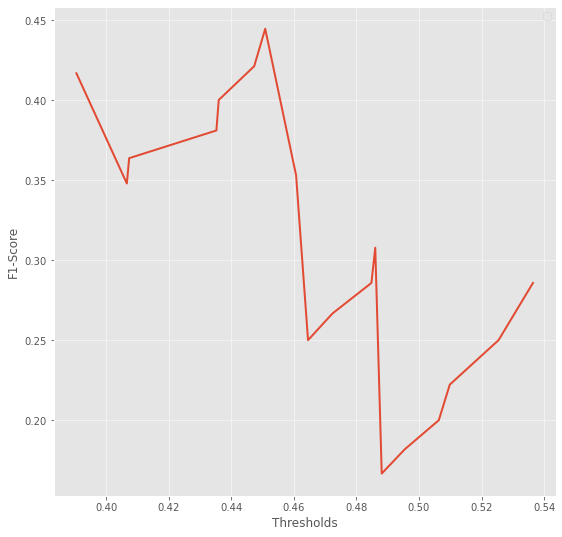

In [52]:
plot_f1_threshold_curve(precision, recall, thresholds)

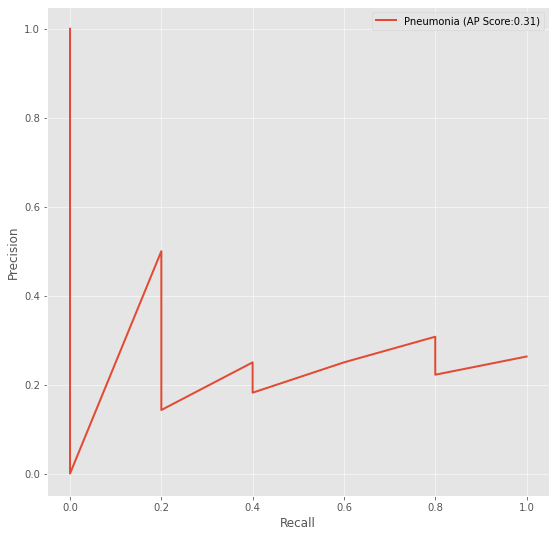

In [53]:
plot_precision_recall_curve(valY, pred_Y)

## Threshold

In [54]:
# Test for different threshold levels
# using colors just to make it easir to read and spot numbers
for t in [0.2, 0.3, 0.4,0.43, 0.45,0.46, 0.47,0.48, 0.49, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    print(f'when threshold at {t} CF:')
    print('Pred: '+str(pred_Y_binary))
    print('Actual: '+str(valY))
    print(confusion_matrix(valY, pred_Y_binary))
    tn, fp, fn, tp = confusion_matrix(valY, pred_Y_binary).ravel()
    print(f'\x1b[34maccuracy \x1b[0m= \x1b[31m{accuracy_score(valY, pred_Y_binary)}\x1b[0m')
    print(f'F1 Score = {f1_score(valY, pred_Y_binary)}')
    print('TP: '+str(tp))
    print('TN: '+str(tn))
    print('FP: '+str(fp))
    print('FN: '+str(fn))
    print(f'\x1b[34mSensitivity Score \x1b[0m= \x1b[31m{tp/(tp+fn)}\x1b[0m')
    print(f'\x1b[34mSpecificity Score \x1b[0m= \x1b[31m{tn/(tn+fp)}\x1b[0m')
    print('-------------------------------')

when threshold at 0.2 CF:
Pred: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Actual: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 0 27]
 [ 0  5]]
accuracy = 0.15625
F1 Score = 0.2702702702702703
TP: 5
TN: 0
FP: 27
FN: 0
Sensitivity Score = 1.0
Specificity Score = 0.0
-------------------------------
when threshold at 0.3 CF:
Pred: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Actual: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
[[ 2 25]
 [ 0  5]]
accuracy = 0.21875
F1 Score = 0.2857142857142857
TP: 5
TN: 2
FP: 25
FN: 0
Sensitivity Score = 1.0
Specificity Score = 0.07407407407407407
-------------------------------
when threshold at 0.4 CF:
Pred: [0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Actual: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0

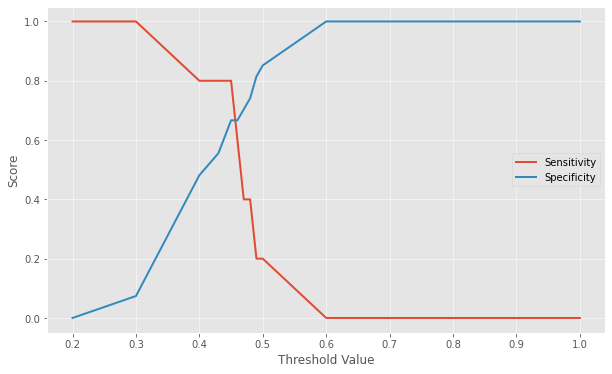

In [55]:
# Test for different threshold levels
# using colors just to make it easir to read and spot numbers
thresholds = [0.2, 0.3, 0.4,0.43, 0.45,0.46, 0.47,0.48, 0.49, 0.5, 0.6,  0.7, 0.8, 0.9, 1]
sens = []
spec = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    tn, fp, fn, tp = confusion_matrix(valY, pred_Y_binary).ravel()
    sens.append(tp/(tp+fn))
    spec.append(tn/(tn+fp))

plt.figure(figsize=(10,6))
plt.plot(thresholds, sens, label='Sensitivity')
plt.plot(thresholds, spec, label='Specificity')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.show()

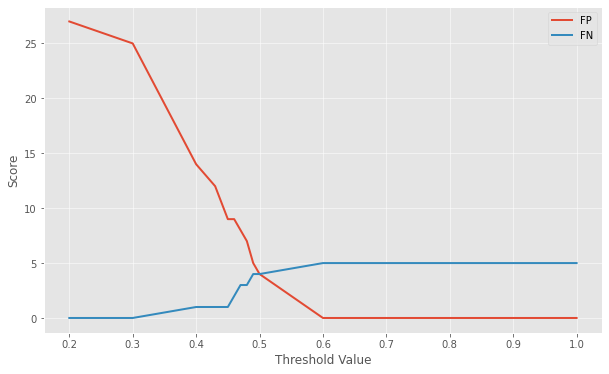

In [56]:
FP = []
FN = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    tn, fp, fn, tp = confusion_matrix(valY, pred_Y_binary).ravel()
    FP.append(fp)
    FN.append(fn)

plt.figure(figsize=(10,6))
plt.plot(thresholds, FP, label='FP')
plt.plot(thresholds, FN, label='FN')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


[0.15625, 0.16666666666666666, 0.2222222222222222, 0.25, 0.3076923076923077, 0.25, 0.2, 0.2222222222222222, 0.16666666666666666, 0.2, nan, nan, nan, nan, nan]


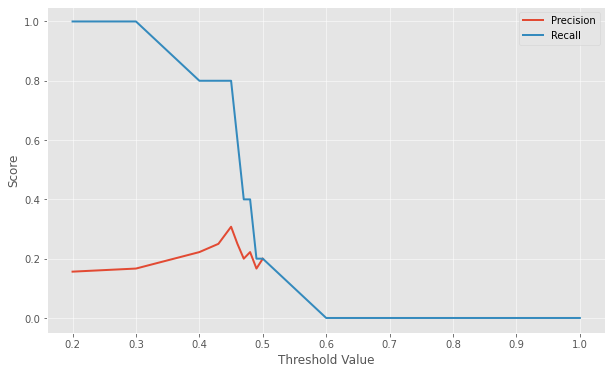

In [57]:
precision_list = []
recall_list = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    tn, fp, fn, tp = confusion_matrix(valY, pred_Y_binary).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    precision_list.append(precision)
    recall_list.append(recall)


print(precision_list)
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.legend()
plt.show()

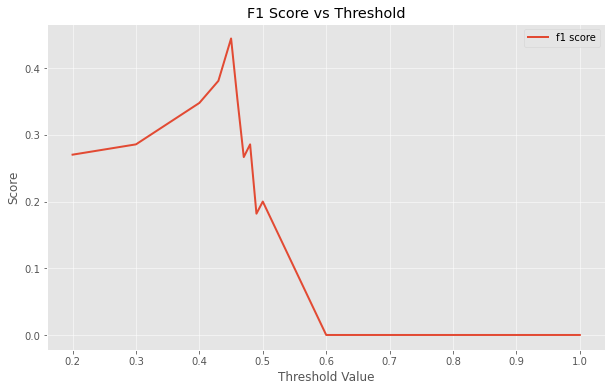

In [58]:
fscore = []
for t in thresholds:
    pred_Y_binary = [1 if i[0] > t else 0 for i in pred_Y]
    fscore.append(f1_score(valY, pred_Y_binary))

plt.figure(figsize=(10,6))
plt.plot(thresholds, fscore, label='f1 score')
plt.xlabel('Threshold Value')
plt.ylabel('Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

# Model Analysis

- The best threshold to choose based on this model is 0.45 given that at such point we can achieve the highest F1-Score (0.44). At such thershold as well we are able to achieve the highest precision (0.3), without compromising so much on recall (0.8) which is a more relevant metric than precision. The best combination so far. At such point: 


### FN vs FP
- When t=0.2 the number of False Positives is really high. This makes sense as with the Threshold being so low, the model classifies everything as positives. As we keep increasing our T, the number of FP decreases.
- Also, after hitting t=0.5 the trends reverse. At that point apparently the model starts to present a bias towards categorizing as negative cases. So, the number of False Negatives start rising.

### Sensitivity vs Specificity
- Specificity starts really high at 1. It is rational that this occurs as our algorithm at this point classifies everything as positive which means we won't have any negative cases hence no False Negatives. But this alone is not a good metric since the number of False positives is really high - which would mean that we are going to tell every patient that comes in that has pneumonia (completely useless).
- We see that Specificity increases as we increase t until hitting again 0.45. Which means that predictions are getting better at classifying the negative cases as well.

### F1

- At t=0.45, F1 Score hits 0.44. The nature of the F1 curve shows that the F1 Score keeps increasing exponentially from t=0.2 until 1 at 0.45. This occurs as the number of false positives decreases.


## Notes
- This model and architecture will benefit of larger training datasets.
- This model and architecture may benefit of longer training time.
- Beyond 0.6 Threshold is all equal to t=0.5. So we kept the threshold analysis up until 0.6
- This conclusion is based off the binary classification evaluation of one specific batch from the validation set of size 32. Other batches or other dataset might reflect a different reality.

In [62]:
tr = 0.45

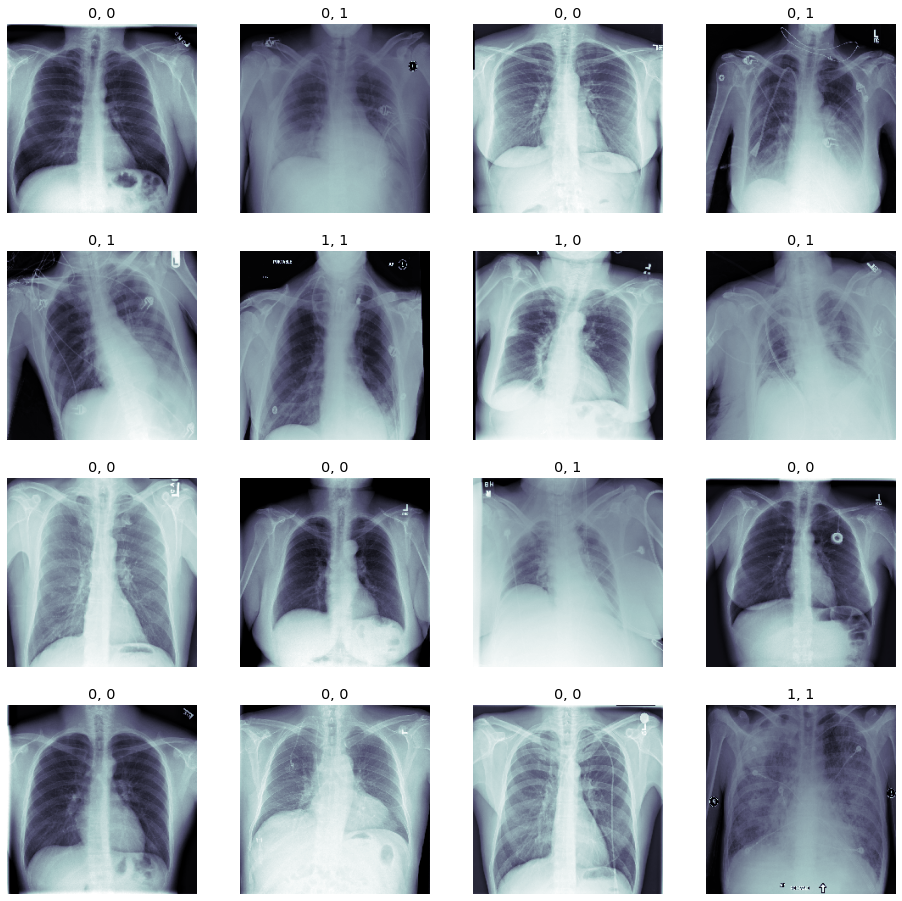

In [63]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], valY[0:16], m_axs.flatten()):
 c_ax.imshow(c_x[:,:,0], cmap = 'bone')
 if c_y == 1: 
     if pred_Y[i] > tr:
         c_ax.set_title('1, 1')
     else:
         c_ax.set_title('1, 0')
 else:
     if pred_Y[i] > tr: 
         c_ax.set_title('0, 1')
     else:
         c_ax.set_title('0, 0')
 c_ax.axis('off')
 i=i+1

In [64]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model_2.json", "w") as json_file:
    json_file.write(model_json)